<a href="https://colab.research.google.com/github/rahul799/RAFSIL/blob/master/aircraft_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
recalimport numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from numpy import loadtxt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform


#from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:


'''Features'''
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

'''Metrics/Evaluation'''
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle
from sklearn.metrics import plot_roc_curve

'''Plotting'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')


''' AUC '''
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot


In [ ]:
train_df = pd.read_csv('/content/drive/My Drive/aircraft_data/PM_train.txt', sep=" ", header=None)
test_df = pd.read_csv('/content/drive/My Drive/aircraft_data/PM_test.txt', sep=" ", header=None)


In [ ]:
#----------------------------------- Train Data -------------------------------------------------------#
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

train_df = train_df.dropna()
train_df.reset_index(drop=True, inplace= True)

X_train = train_df.copy()

w1 = 30
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
Y_train = train_df["label1"].copy()


X_train.index = range(len(X_train))

Y_train.index = range(len(Y_train))
 
#-------------------------------------------------------------------------------------------------------# 

#----------------------------------- Test Data ---------------------------------------------------------#

test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

test_df = test_df.sort_values(['id','cycle'])

rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
test_df = test_df.merge(rul, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

test_df = test_df.dropna()
test_df.reset_index(drop=True, inplace= True)


X1_test = test_df.copy()

w1 = 30
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
Y1_test = test_df["label1"].copy()

X1_test.index = range(len(X1_test))

Y1_test.index = range(len(Y1_test))
 
#-------------------------------------------------------------------------------------------------------# 

In [ ]:
# Current Class Distributoin
Y1_test.value_counts()


0    9087
1    2851
Name: label1, dtype: int64

In [ ]:
# Drop Unwanted Columns

cols_to_be_dropped = ["RUL", "label1", "id", "cycle"] + ['s8', 'setting2', 'setting1', 's6', 'setting3', 's1', 's19', 's18', 's5', 's16', 's10']
train_df = train_df.drop(cols_to_be_dropped, axis = 1)
test_df = test_df.drop(cols_to_be_dropped, axis = 1)

cols_to_be_dropped_in_X = ["RUL", "id", "cycle"] + ['s8', 'setting2', 'setting1', 's6', 'setting3', 's1', 's19', 's18', 's5', 's16', 's10']
X_train = X_train.drop(cols_to_be_dropped_in_X, axis = 1)
X1_test = X1_test.drop(cols_to_be_dropped_in_X, axis = 1)

In [ ]:
# Current Class Distributoin
Y_train.value_counts()


0    17531
1     3100
Name: label1, dtype: int64

In [ ]:
# Performin over sampling due to imbalenced class in dataset

X_train_oversampled, Y_train_oversampled = SMOTE().fit_resample(X_train, Y_train)

# Retainning the pandas dataframe
X_train = pd.DataFrame(X_train_oversampled, columns=X_train.columns)
Y_train = pd.DataFrame(Y_train_oversampled)

In [ ]:
X_train

,s2,s3,s4,s7,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,641.820000,1589.700000,1400.600000,554.360000,9046.190000,47.470000,521.660000,2388.020000,8138.620000,8.419500,392.000000,39.060000,23.419000
1,642.150000,1591.820000,1403.140000,553.750000,9044.070000,47.490000,522.280000,2388.070000,8131.490000,8.431800,392.000000,39.000000,23.423600
2,642.350000,1587.990000,1404.200000,554.260000,9052.940000,47.270000,522.420000,2388.030000,8133.230000,8.417800,390.000000,38.950000,23.344200
3,642.350000,1582.790000,1401.870000,554.450000,9049.480000,47.130000,522.860000,2388.080000,8133.830000,8.368200,392.000000,38.880000,23.373900
4,642.370000,1582.850000,1406.220000,554.000000,9055.150000,47.280000,522.190000,2388.040000,8133.800000,8.429400,393.000000,38.900000,23.404400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35057,642.624114,1602.644633,1424.150945,553.126738,9162.429645,47.760804,520.896028,2388.060804,8229.032459,8.479192,395.879432,38.630000,23.239560
35058,643.423701,1602.307036,1422.740753,552.154078,9058.929267,47.885553,520.013333,2388.227778,8133.865920,8.515504,395.518505,38.621112,23.222894
35059,643.098993,1600.787460,1415.553370,552.525252,9154.046148,47.700394,521.328512,2388.079869,8226.379473,8.459116,393.995623,38.690481,23.319500
35060,643.775357,1599.903115,1423.528656,552.601789,9111.690529,47.937414,520.290084,2388.158304,8179.986348,8.500081,396.267842,38.500269,23.141627


In [ ]:
# Oversampled Class Distributoin
Y_train.value_counts()


1    17531
0    17531
dtype: int64

In [ ]:
# Create a function

train_df.dtypes
categorical_colunms = ["id"]
numerical_colunms = []
for col,type_ in train_df.dtypes.iteritems():
    if col == "id":
        continue
    if type_ == 'int64' or type_ == 'float64':
        numerical_colunms.append(col)
    elif type_ == 'object':
        categorical_colunms.append(col)



print("Numerical Colunms: {0}".format(", ".join(numerical_colunms)))
print("Categorical Colunms: {0}".format(", ".join(categorical_colunms)))

Numerical Colunms: s2, s3, s4, s7, s9, s11, s12, s13, s14, s15, s17, s20, s21
Categorical Colunms: id


In [ ]:
# Preprocessing
# 1. Outlier Capping
def capping(df, lower_cap = 0.01, upper_cap = 0.99):
  for col in numerical_colunms:
    low_bound = df[col].quantile(lower_cap)
    up_bound = df[col].quantile(upper_cap)
    capped_df[col] = df[col].clip(lower=low_bound, upper=up_bound)
  return capped_df

# 2. Filling Missing Values
def df_fact_missing(df, categorical_var_list, numerical_var_list):
    for fac_col in categorical_var_list:
        df[fac_col] = df[fac_col].fillna("Unknown")
    for non_fac_col in numerical_var_list:
        df[non_fac_col] = df[non_fac_col].fillna(-99999)
    return df

In [ ]:
class MultiColumnLabelEncoder:
 def __init__(self,columns = None):
  self.columns = columns # array of column names to encode
 
 def fit(self,X,y=None):
  return self # not relevant here
 
 def transform(self,X):
  '''
  Transforms columns of X specified in self.columns using
  LabelEncoder(). If no columns specified, transforms all
  columns in X.
  '''
  output = X.copy()
  if self.columns is not None:
    for col in self.columns:
     output[col] = LabelEncoder().fit_transform(output[col])
  else:
    for colname,col in output.iteritems():
     output[colname] = LabelEncoder().fit_transform(col)
  return output
 
 def fit_transform(self,X,y=None):
  return self.fit(X,y).transform(X)

In [ ]:
# Run If needed
#MultiColumnLabelEncoder(columns = categorical_colunms ).fit_transform(train_df)

In [ ]:
# Splitting Test data into test and validation

X_test, X_val, Y_test, Y_val = train_test_split(test_df, Y1_test, test_size = 0.5, random_state=3)

In [ ]:
# One Hot Encoding
make_dummies = False
if make_dummies:
  X_train_dummy = pd.get_dummies(X_train, columns = categorical_colunms)
  X_val_dummy = pd.get_dummies(X_val, columns = categorical_colunms)
  X_test_dummy = pd.get_dummies(X_test, columns = categorical_colunms)
else:
  X_train_dummy = X_train.copy()
  X_val_dummy = X_val.copy()
  X_test_dummy = X_test.copy()  

In [ ]:
# Creating columns of unavialable categories in validation and testing df

final_column_train = X_train_dummy.columns.to_list()
for col in final_column_train:
  if col not in X_val_dummy.columns:
    X_val_dummy[col] = 0
  if col not in X_test_dummy.columns:
    X_test_dummy[col] = 0

In [ ]:
# Creating columns of unavialable categories in validation and testing df

final_column_test = X_test_dummy.columns.to_list()
cols_to_drop_from_test = []

for col in final_column_test:
  if col not in final_column_train:
    cols_to_drop_from_test.append(col)


In [ ]:
# Creating columns of unavialable categories in validation and testing df

final_column_val = X_val_dummy.columns.to_list()
cols_to_drop_from_val = []

for col in final_column_val:
  if col not in final_column_train:
    cols_to_drop_from_val.append(col)

In [ ]:
X_val_dummy = X_val_dummy.drop(cols_to_drop_from_val, axis=1)
X_test_dummy = X_test_dummy.drop(cols_to_drop_from_test, axis=1) 

In [ ]:

X_train_dummy = X_train_dummy[final_column_train]
X_val_dummy = X_val_dummy[final_column_train]
X_test_dummy = X_test_dummy[final_column_train]


In [ ]:
#Preliminary model evaluation using default parameters

#Creating a dict of the models
model_dict = {
              'Random Forest': RandomForestClassifier(random_state=3, n_estimators=300, min_samples_leaf=5, min_samples_split=10),
              'Logistic Regression' : LogisticRegression(random_state=3,max_iter=1000),
              "XGBoost" : XGBClassifier(n_estimators=300, random_state=3, max_leaves =5, colsample_bytree =0.7,max_depth=7),
              "Light gbm" : LGBMClassifier(n_estimators=300, random_state=3, min_child_samples = 30)
              }


#Function to get the scores for each model in a df
def model_score_df(model_dict, X_train, X_test, y_train, y_test):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list, auc_score_list = [], [], [], [], [], []
    for k,v in model_dict.items(): 
        model_name.append(k)
        print("Fitting Model - ", k)
        v.fit(X_train, y_train)

        #--------------------AUC------------------#
        lr_probs = v.predict_proba(X_test)
        # keep probabilities for the positive outcome only
        lr_probs = lr_probs[:, 1]
        auc_score = roc_auc_score(y_test, lr_probs)

        y_pred = v.predict(X_test)        
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='micro'))
        r_score_list.append(recall_score(y_test, y_pred, average='micro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='micro'))
        auc_score_list.append(auc_score)
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list, auc_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score', 'auc_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
        
    return (model_comparison_df)

In [ ]:
k= model_score_df(model_dict, X_train_dummy, X_val_dummy, Y_train.values.ravel(), Y_val)
k

Fitting Model -  Random Forest
Fitting Model -  Logistic Regression
Fitting Model -  XGBoost
Fitting Model -  Light gbm


,model_name,accuracy_score,precision_score,recall_score,f1_score,auc_score
1,Logistic Regression,0.791757,0.791757,0.791757,0.791757,0.738955
0,Random Forest,0.788072,0.788072,0.788072,0.788072,0.690935
2,XGBoost,0.783716,0.783716,0.783716,0.783716,0.733417
3,Light gbm,0.782041,0.782041,0.782041,0.782041,0.728669


# **Hyperparameter Tuning**

In [ ]:
# # Hyperparameter tuning: Random Forest

# #RF
# max_depth = [10, 50, 100]
# max_features = ['auto', 'sqrt']
# min_samples_leaf = [1, 2, 4]
# min_samples_split = [2, 5, 10]
# n_estimators = [300, 400, 450]
# random_state = [3]

# clf = RandomForestClassifier()

# params = dict(max_depth = max_depth,
#               max_features = max_features,
#               min_samples_leaf = min_samples_leaf,
#               n_estimators = n_estimators,
#               random_state=random_state)

# gridsearch = GridSearchCV(clf,
#                           params, 
#                           cv=5,
#                           verbose=1, 
#                           n_jobs=-1)

# rf_best_model = gridsearch.fit(X_train, Y_train)

In [ ]:
# # Hyperparameter tuning: XGBoost

fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,Y_test)],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100}

param_test = {
            'n_estimators': [300, 350, 400],
            'min_child_weight': [1, 5, 10],
            'subsample': [0.6, 0.8],
            'colsample_bytree': [0.6, 0.7],
            'max_depth': [4, 5]}


n_HP_points_to_test = 100

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 500 define only the absolute maximum
clf = XGBClassifier(random_state=314, silent=True, metric='None', n_jobs=4)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=3,
    verbose=True)

gs.fit(X_train, Y_train.values.ravel(), **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

# {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 5, 'colsample_bytree': 0.6}


In [ ]:
# # Hyperparameter tuning: LighGBM
# fit_params={"early_stopping_rounds":30, 
#             "eval_metric" : 'auc', 
#             "eval_set" : [(X_test,Y_test)],
#             'eval_names': ['valid'],
#             #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
#             'verbose': 100,
#             'categorical_feature': 'auto'}

# param_test = {
#     'learning_rate': [0.005],
#     'min_child_samples': [20, 40, 50],
#     'n_estimators': [300, 350, 400],
#     'num_leaves': [6,8,12],
#     'boosting_type' : ['gbdt'],
#     'objective' : ['binary'],
#     'colsample_bytree' : [0.6, 0.7],
#     'subsample' : [0.7,0.75],
#     'reg_alpha' : [1,1.2],
#     'reg_lambda' : [1,1.2,1.4]}


# n_HP_points_to_test = 100

# #n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 500 define only the absolute maximum
# clf = LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4)
# gs = RandomizedSearchCV(
#     estimator=clf, param_distributions=param_test, 
#     n_iter=n_HP_points_to_test,
#     scoring='roc_auc',
#     cv=3,
#     refit=True,
#     random_state=3,
#     verbose=True)

# gs.fit(X_train, Y_train.values.ravel(), **fit_params)
# print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))


# # Best params: {'subsample': 0.7, 'reg_lambda': 1.4, 'reg_alpha': 1, 'objective': 'binary', 'num_leaves': 12, 'n_estimators': 400, 'min_child_samples': 50, 'learning_rate': 0.005, 'colsample_bytree': 0.7, 'boosting_type': 'gbdt'}



# **Feature Importance**

In [ ]:
# Feature Importance
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def plotImp(model, X , num = 20, fig_size = (40, 20)):
    boost = model.booster_
    feature_imp = pd.DataFrame({'Value':boost.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

In [ ]:
# clf = LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=500)
# clf.fit(X_train,Y_train.values.ravel())
# plotImp(clf, X_train)

In [ ]:
# Build a forest and compute the feature importances
XGB_Model = XGBClassifier(random_state=314, subsample = 0.8, n_estimators = 300, min_child_weight = 1, max_depth = 5, colsample_bytree = 0.6)
XGB_Model.fit(X_train, Y_train)

#importances = forest.feature_importances_
importances= XGB_Model.feature_importances_
indices= np.argsort(importances)[::1]

feat_importances= pd.Series(XGB_Model.feature_importances_,index= X_train.columns)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Perfomance Metrics
predictions = XGB_Model.predict(X_test)

predictions_scores = XGB_Model.predict_proba(X_test)
predictions_scores = predictions_scores[:, 1]

# Extract Accuracy/Precision/AUC/Recall
df = pd.DataFrame({'Real Values':Y_test, 'Predicted Values':predictions})

accuracy = accuracy_score(Y_test, predictions)
precision = precision_score(Y_test, predictions)
recall = recall_score(Y_test, predictions)
auc_score = roc_auc_score(Y_test, predictions_scores)

print("accuracy: ", accuracy, "precision: ", precision, "recall: ", recall, "auc_score: ", auc_score)

accuracy:  0.782208075054448 precision:  0.9758064516129032 recall:  0.08533145275035262 auc_score:  0.7209080662071821


In [ ]:
conf_data = {'y_Actual':    Y_test,
        'y_Predicted': predictions
        }

confusion_df = pd.DataFrame(conf_data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(confusion_df['y_Actual'], confusion_df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)



Predicted     0    1
Actual              
0          4548    3
1          1297  121


In [ ]:
# Performing k-Fold cross validation

skf = StratifiedKFold(n_splits=5)

skf.get_n_splits(X_train, Y_train)

performance_df = pd.DataFrame()

performance_list = []

counter = 0

for train_index, test_index in skf.split(X_train, Y_train):

    counter += 1

    # print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train_Kfold, X_test_Kfold = X_train[X_train.index.isin(train_index)].to_numpy(), X_train[X_train.index.isin(test_index)].to_numpy()
    y_train_Kfold, y_test_Kfold = Y_train[Y_train.index.isin(train_index)].to_numpy().flatten(), Y_train[Y_train.index.isin(test_index)].to_numpy().flatten()

    # classifier = RandomForestClassifier(n_estimators = 10, random_state = 0)
    classifier = GaussianNB()
    classifier.fit(X_train_Kfold, y_train_Kfold)
    
    predictions = classifier.predict(X_test_Kfold)
    
    predictions_scores = classifier.predict_proba(X_test_Kfold)
    predictions_scores = predictions_scores[:, 1]
    
    # Extract Accuracy/Precision/AUC/Recall
    df = pd.DataFrame({'Real Values':y_test_Kfold, 'Predicted Values':predictions})

    accuracy = accuracy_score(y_test_Kfold, predictions)
    precision = precision_score(y_test_Kfold, predictions)
    recall = recall_score(y_test_Kfold, predictions)
    auc_score = roc_auc_score(y_test_Kfold, predictions_scores)

    performance_list.append(["Fold-" + str(counter), auc_score, precision, recall, accuracy])
    
    
performance_list = pd.DataFrame(performance_list, columns=["n-fold", "AUC", "Precision", "Recall", "Accuracy"])
# performance_list.to_excel("/content/drive/My Drive/Colab Notebooks/aircraft_data/accuracy.xlsx", index = False)

In [ ]:
performance_list

,n-fold,AUC,Precision,Recall,Accuracy
0,Fold-1,0.991312,0.929138,0.968625,0.947383
1,Fold-2,0.992620,0.920482,0.980325,0.947811
2,Fold-3,0.992744,0.943054,0.977752,0.959355
3,Fold-4,0.984020,0.894943,0.979179,0.932116
4,Fold-5,0.987917,0.915504,0.973474,0.941814


In [ ]:
X_train.drop(["id", "cycle"], axis = 1)

,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,-0.000700,-0.000400,100.0,518.67,641.820000,1589.700000,1400.600000,14.62,21.61,554.360000,2388.060000,9046.190000,1.3,47.470000,521.660000,2388.020000,8138.620000,8.419500,0.03,392.000000,2388.0,100.0,39.060000,23.419000
1,0.001900,-0.000300,100.0,518.67,642.150000,1591.820000,1403.140000,14.62,21.61,553.750000,2388.040000,9044.070000,1.3,47.490000,522.280000,2388.070000,8131.490000,8.431800,0.03,392.000000,2388.0,100.0,39.000000,23.423600
2,-0.004300,0.000300,100.0,518.67,642.350000,1587.990000,1404.200000,14.62,21.61,554.260000,2388.080000,9052.940000,1.3,47.270000,522.420000,2388.030000,8133.230000,8.417800,0.03,390.000000,2388.0,100.0,38.950000,23.344200
3,0.000700,0.000000,100.0,518.67,642.350000,1582.790000,1401.870000,14.62,21.61,554.450000,2388.110000,9049.480000,1.3,47.130000,522.860000,2388.080000,8133.830000,8.368200,0.03,392.000000,2388.0,100.0,38.880000,23.373900
4,-0.001900,-0.000200,100.0,518.67,642.370000,1582.850000,1406.220000,14.62,21.61,554.000000,2388.060000,9055.150000,1.3,47.280000,522.190000,2388.040000,8133.800000,8.429400,0.03,393.000000,2388.0,100.0,38.900000,23.404400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35057,0.000747,-0.000011,100.0,518.67,643.245256,1593.682510,1418.220888,14.62,21.61,552.174812,2388.185256,9124.343584,1.3,47.894727,520.771092,2388.147884,8193.923907,8.521884,0.03,396.315700,2388.0,100.0,38.630512,23.176378
35058,-0.001910,0.000400,100.0,518.67,643.122356,1595.776743,1422.332875,14.62,21.61,552.728631,2388.151123,9126.302771,1.3,47.872027,520.785616,2388.125507,8194.239508,8.481534,0.03,395.887670,2388.0,100.0,38.695397,23.147685
35059,0.001852,-0.000058,100.0,518.67,643.023930,1601.257222,1423.053054,14.62,21.61,552.443129,2388.103229,9165.364279,1.3,47.847109,520.919036,2388.106458,8227.881778,8.485966,0.03,396.000000,2388.0,100.0,38.548698,23.158521
35060,-0.000023,-0.000258,100.0,518.67,643.275793,1592.815305,1415.068777,14.62,21.61,552.843437,2388.160771,9058.615128,1.3,47.947688,520.448087,2388.170771,8135.127236,8.450224,0.03,393.269265,2388.0,100.0,38.602312,23.155057


In [ ]:
# Final Model Build
# bin_model_class = RandomForestClassifier(n_estimators=100, max_depth = 5, min_samples_split=2, max_features='sqrt', oob_score=False)
# {'subsample': 0.75, 'reg_lambda': 1.2, 'reg_alpha': 1.2, 'objective': 'binary', 'num_leaves': 16, 'n_estimators': 400, 'min_child_samples': 20, 'learning_rate': 0.005, 'colsample_bytree': 0.7, 'boosting_type': 'gbdt'
bin_model_class = LGBMClassifier(subsample=0.75, reg_lambda=1.2, reg_alpha=1.2, objective='binary', num_leaves=16, n_estimators=400, min_child_samples=20, learning_rate=0.005, colsample_bytree=0.7, boosting_type='gbdt')
bin_model_class.fit(X_train, Y_train)
predictions = bin_model_class.predict(X_test)
predictions_scores = bin_model_class.predict_proba(X_test)
predictions_scores = predictions_scores[:, 1]
auc_score = roc_auc_score(Y_test, predictions_scores)
auc_score

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6997231501686421

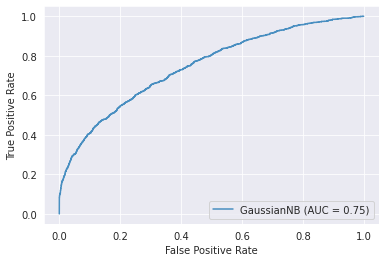

In [ ]:
ax = plt.gca()
rfc_disp = plot_roc_curve(bin_model_class, X_test, Y_test, ax=ax, alpha=0.8)
plt.show()

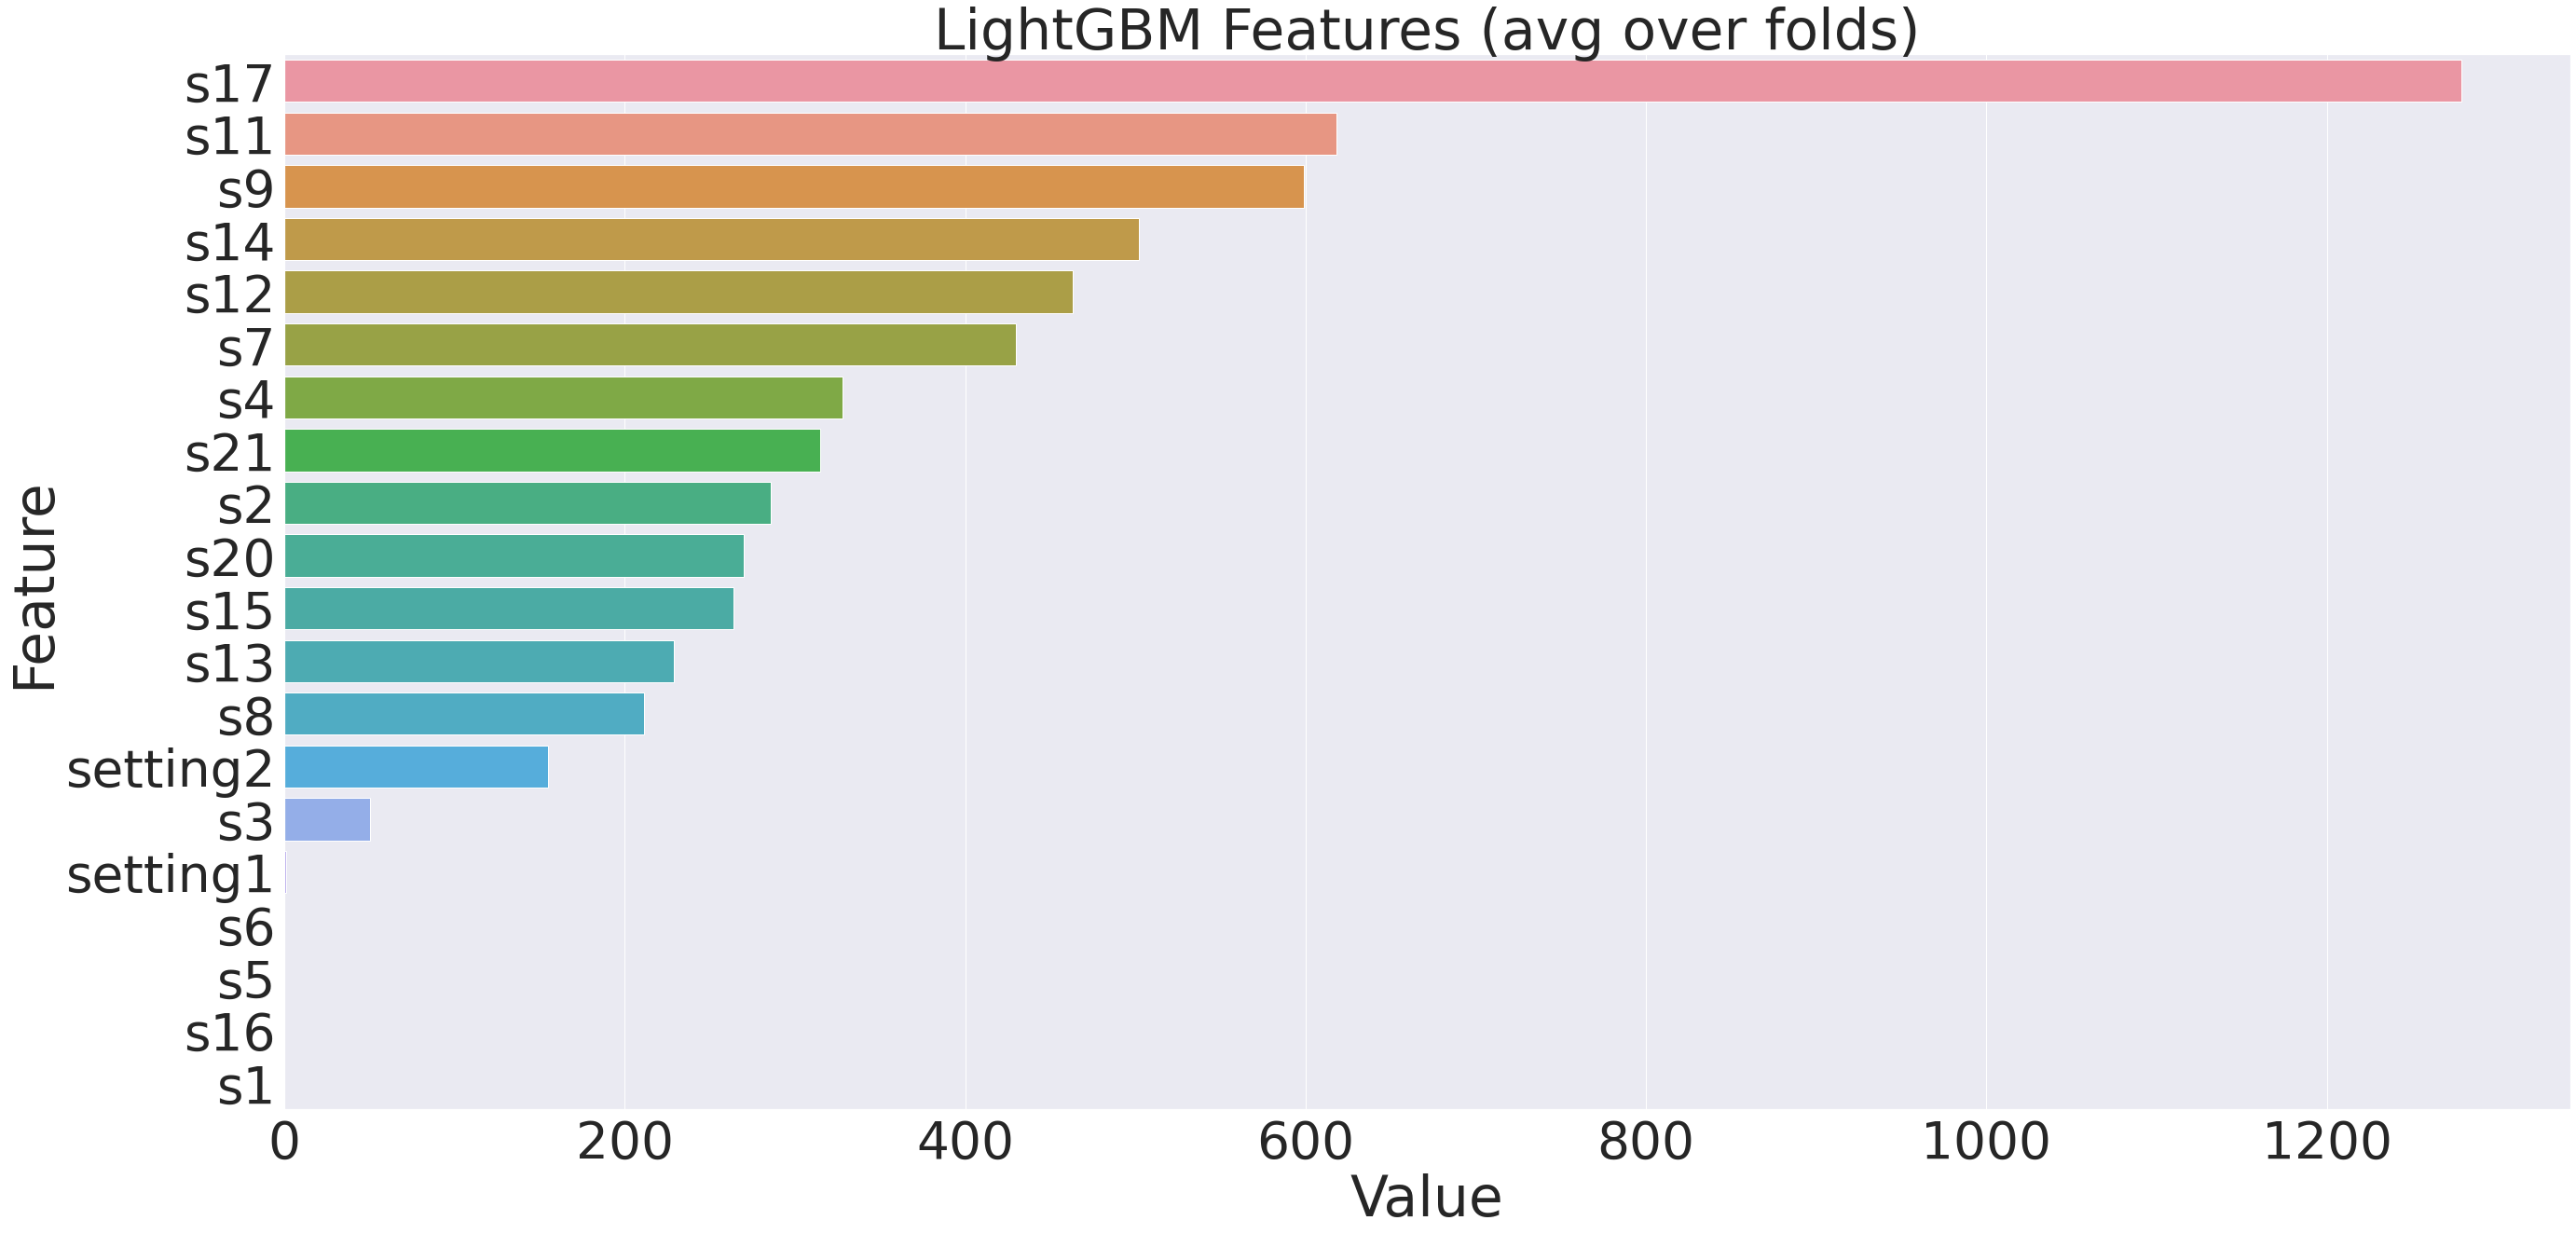

In [ ]:
plotImp(bin_model_class, X_train)